C:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3897
           1       0.94      0.94      0.94     24021
           2       0.91      0.91      0.91     16082

    accuracy                           0.94     44000
   macro avg       0.95      0.95      0.95     44000
weighted avg       0.94      0.94      0.94     44000



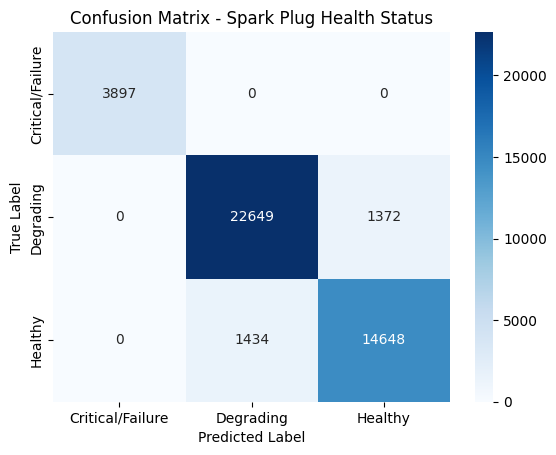

Subset 1 - R² Score: 0.9817, MSE: 8.3248, MAE: 1.8696
Subset 2 - R² Score: 0.9817, MSE: 8.2284, MAE: 1.8704
Subset 3 - R² Score: 0.9812, MSE: 8.5349, MAE: 1.8928
Subset 4 - R² Score: 0.9814, MSE: 8.3440, MAE: 1.8754
Subset 5 - R² Score: 0.9813, MSE: 8.4685, MAE: 1.8872
Overall Regression Model R² Score: 0.9399
Overall Regression Model MSE: 26.9496
Overall Regression Model MAE: 3.8016
The model performs very well, accurately predicting spark plug performance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

file_path = "sparkplug_final_faults.csv"
df = pd.read_csv(file_path)

df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True).str.replace(" ", "_")

def classify_health(performance):
    if performance >= 80:
        return 2  
    elif 50 <= performance < 80:
        return 1 
    else:
        return 0  

df["HealthStatus"] = df["SparkPlugPerformance"].apply(classify_health)

X_class = df.drop(columns=["SparkPlugPerformance", "HealthStatus"])
y_class = df["HealthStatus"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_c, y_train_c)

y_pred_class = xgb_model.predict(X_test_c)
print("Classification Report:")
print(classification_report(y_test_c, y_pred_class))

conf_matrix = confusion_matrix(y_test_c, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Critical/Failure", "Degrading", "Healthy"], yticklabels=["Critical/Failure", "Degrading", "Healthy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Spark Plug Health Status")
plt.show()

X_train_c = X_train_c.copy()
X_test_c = X_test_c.copy()
X_train_c["PredictedHealthStatus"] = xgb_model.predict(X_train_c)
X_test_c["PredictedHealthStatus"] = y_pred_class

X_reg = X_train_c
y_reg = df.loc[X_train_c.index, "SparkPlugPerformance"]

X_test_reg = X_test_c
y_test_reg = df.loc[X_test_c.index, "SparkPlugPerformance"]

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_reg, y_reg)

num_subsets = 5
df_subsets = np.array_split(df, num_subsets)

for i, subset in enumerate(df_subsets):
    X_subset = subset.drop(columns=["SparkPlugPerformance", "HealthStatus"])
    X_subset["PredictedHealthStatus"] = xgb_model.predict(X_subset)
    y_subset = subset["SparkPlugPerformance"]
    y_pred_subset = rf_regressor.predict(X_subset)
    r2_subset = r2_score(y_subset, y_pred_subset)
    mse_subset = mean_squared_error(y_subset, y_pred_subset)
    mae_subset = mean_absolute_error(y_subset, y_pred_subset)
    print(f"Subset {i+1} - R² Score: {r2_subset:.4f}, MSE: {mse_subset:.4f}, MAE: {mae_subset:.4f}")

y_pred_reg = rf_regressor.predict(X_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Overall Regression Model R² Score: {r2:.4f}")
print(f"Overall Regression Model MSE: {mse:.4f}")
print(f"Overall Regression Model MAE: {mae:.4f}")

if r2 > 0.8:
    print("The model performs very well, accurately predicting spark plug performance.")
elif r2 > 0.6:
    print("The model performs decently but could be improved with additional features or tuning.")
else:
    print("The model has poor predictive power; more feature engineering and tuning may be needed.")